# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

### Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

### Helper Functions

In [2]:

def hsvscale(img):
    """Applies the HSVscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def hsv_mask(img):
    """Applies the HSV mask for white & yellow colors"""
    # Define the lower and upper bounds for the white color
    white_lwr = np.array([0, 0, 200])
    white_upr = np.array([180, 255, 255])
    
    # Define the lower and upper bounds for the yellow color
    yellow_lwr = np.array([20, 100, 100])
    yellow_upr = np.array([30, 255, 255])
    
    # Convert the scale from BGR to HSV
    hsv_img = hsvscale(img)
    
    # Get the white color mask
    white_mask = cv2.inRange(hsv_img, white_lwr, white_upr)


    # Get the yellow color mask
    yellow_mask = cv2.inRange(hsv_img, yellow_lwr, yellow_upr)
    
    # Combine two masks
    mask_combined = white_mask | yellow_mask

    # Use bitwise_and to mask the original image
    return cv2.bitwise_and(img, img, mask=mask_combined)


def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

            
def draw_lines_ext(img, lines, color=[255, 0, 0], thickness=5):
    """
    This function draws `lines` with `color` and `thickness`.
    Lines are devided into two groups, positive & negtive, by their 
    slope ((y2-y1)/(x2-x1)). Then within each group, average/extrapolate 
    the line segments to map out the full extent of the lane  
    """
    slopes=[]

    #calculate slopes for each line to identify the positive and negative lines
    pos_lines = []
    neg_lines = []
    
    #set pos_min_slope/neg_max_slope to remove the near-horizontal lines
    pos_min_slope = np.pi*10/180
    neg_max_slope = -pos_min_slope
    
    img_shape = img.shape
    min_y=img_shape[0]
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            length = math.sqrt((y2 - y1)**2.0 + (x2 - x1)**2.0)
            if slope > pos_min_slope:
                pos_lines.append((slope, intercept, length))
            elif slope < neg_max_slope:
                neg_lines.append((slope, intercept, length))
            else:
                pass

    min_y = np.amin(lines[:,:,[1,3]])
        
    pos_lines = np.array(pos_lines)
    neg_lines = np.array(neg_lines)

    #remove outliers
    pos_lines = pos_lines[to_keep_index(pos_lines[:, 0])]
    neg_lines = neg_lines[to_keep_index(neg_lines[:, 0])]

    
    # Find the average slope and intercept for each line
    # Use line lengths as the weights so that longer segments dominate the averages

    pos_lines_slope = np.average(pos_lines[:, 0], weights=pos_lines[:, 2])
    pos_lines_intercept = np.average(pos_lines[:, 1], weights=pos_lines[:, 2])

    neg_lines_slope = np.average(neg_lines[:, 0], weights=neg_lines[:, 2])
    neg_lines_intercept = np.average(neg_lines[:, 1], weights=neg_lines[:, 2])

    
    pos_y1 = img_shape[0]
    pos_x1 = int((pos_y1 - pos_lines_intercept) / pos_lines_slope)

    pos_y2 = min_y
    pos_x2 = int((pos_y2 - pos_lines_intercept) / pos_lines_slope)

    neg_y1 = img_shape[0]
    neg_x1 = int((neg_y1 - neg_lines_intercept) / neg_lines_slope)

    neg_y2 = min_y
    neg_x2 = int((neg_y2 - neg_lines_intercept) / neg_lines_slope)
    
    cv2.line(img, (pos_x1, pos_y1), (pos_x2, pos_y2), color, thickness)
    cv2.line(img, (neg_x1, neg_y1), (neg_x2, neg_y2), color, thickness)
    

## removing the outliers 
def to_keep_index(obs, std=1.5):
    """
    Detect the outliers using standard deviation
    """
    return np.array(abs(obs - np.mean(obs)) < std*np.std(obs))
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_ext(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Build a Lane Finding Pipeline



In [3]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def pipeline(img):

    # Apply color selection
    hsv_masked_image = hsv_mask(img)

    # Convert it into grayscale and display again
    gray = grayscale(hsv_masked_image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define a four sided polygon to mask
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_roi = region_of_interest(edges, vertices)
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 5 
    lines = hough_lines(edges_roi, rho, theta, threshold, min_line_length, max_line_gap)

    img_output = weighted_img(lines, img)
    
    return hsv_masked_image, gray, edges_roi, img_output

### Test Images

Test the pipeline on the images in the directory "test_images"  

SOLIDWHITECURVE.JPG
test_images_output/solidWhiteCurve_hsvMasked.jpg


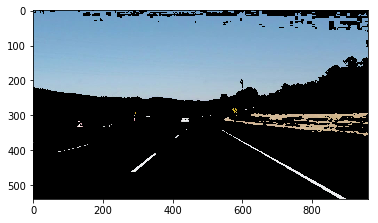

test_images_output/solidWhiteCurve_gray.jpg


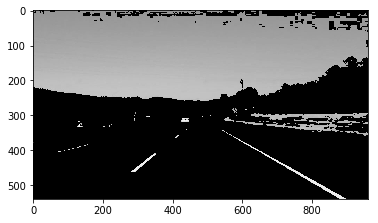

test_images_output/solidWhiteCurve_edge.jpg


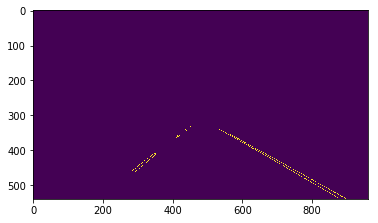

test_images_output/solidWhiteCurve_out.jpg


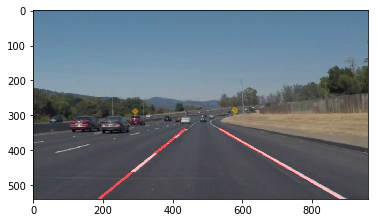

SOLIDWHITERIGHT.JPG
test_images_output/solidWhiteRight_hsvMasked.jpg


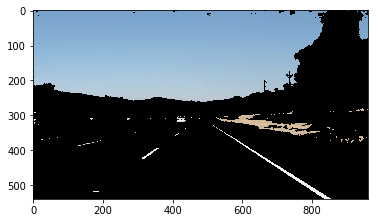

test_images_output/solidWhiteRight_gray.jpg


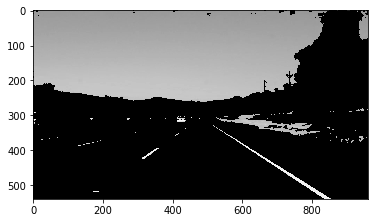

test_images_output/solidWhiteRight_edge.jpg


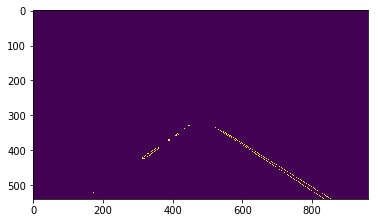

test_images_output/solidWhiteRight_out.jpg


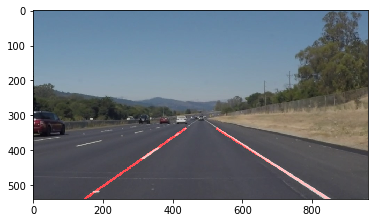

SOLIDYELLOWCURVE.JPG
test_images_output/solidYellowCurve_hsvMasked.jpg


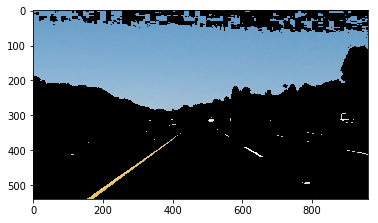

test_images_output/solidYellowCurve_gray.jpg


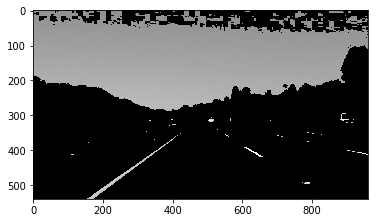

test_images_output/solidYellowCurve_edge.jpg


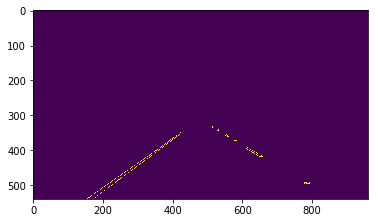

test_images_output/solidYellowCurve_out.jpg


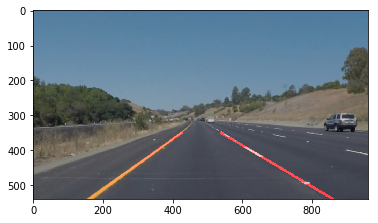

SOLIDYELLOWCURVE2.JPG
test_images_output/solidYellowCurve2_hsvMasked.jpg


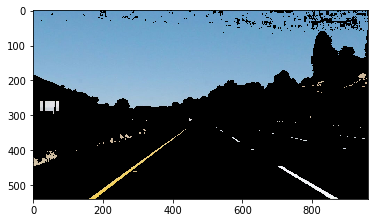

test_images_output/solidYellowCurve2_gray.jpg


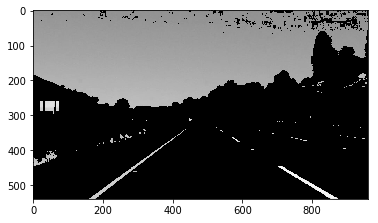

test_images_output/solidYellowCurve2_edge.jpg


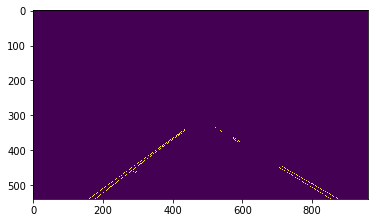

test_images_output/solidYellowCurve2_out.jpg


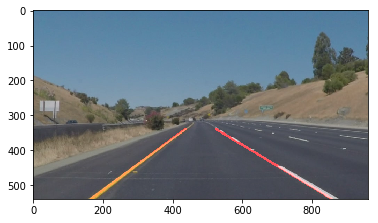

SOLIDYELLOWLEFT.JPG
test_images_output/solidYellowLeft_hsvMasked.jpg


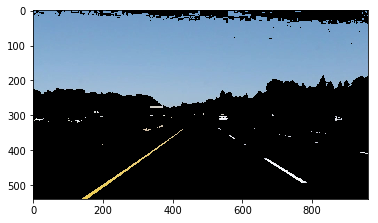

test_images_output/solidYellowLeft_gray.jpg


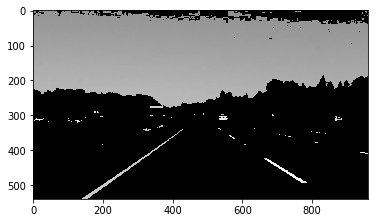

test_images_output/solidYellowLeft_edge.jpg


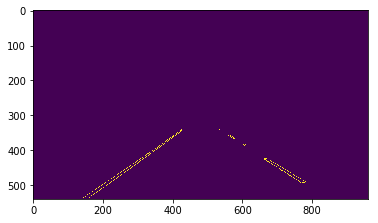

test_images_output/solidYellowLeft_out.jpg


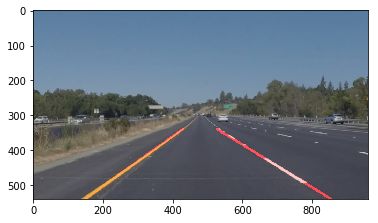

WHITECARLANESWITCH.JPG
test_images_output/whiteCarLaneSwitch_hsvMasked.jpg


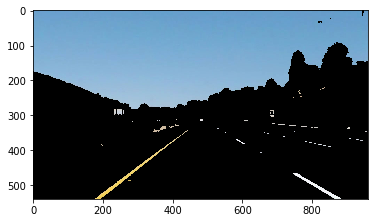

test_images_output/whiteCarLaneSwitch_gray.jpg


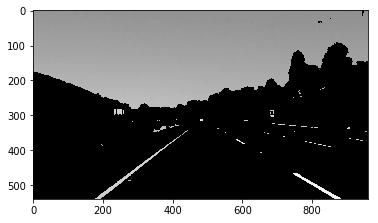

test_images_output/whiteCarLaneSwitch_edge.jpg


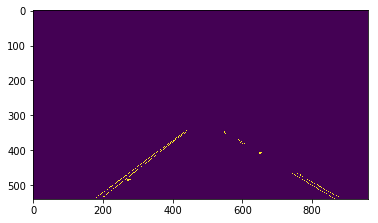

test_images_output/whiteCarLaneSwitch_out.jpg


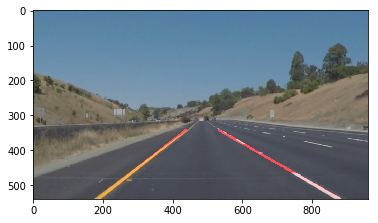

In [4]:
import os

for img_name in os.listdir("test_images/"):
    folder_name = "test_images"
    path = folder_name + "/" + img_name
    image = mpimg.imread(path)
        
    print(img_name.upper())
        
    hsv_masked_image, gray, edges_roi, image_output = pipeline(image)
        
    nm, ext = img_name.split(".")
    
    out_file_name = "test_images_output/" + nm + "_hsvMasked." + ext
    print(out_file_name)
    cv2.imwrite(out_file_name, cv2.cvtColor(hsv_masked_image, cv2.COLOR_BGR2RGB ))
    plt.imshow(hsv_masked_image)
    plt.show()
    
    out_file_name = "test_images_output/" + nm + "_gray." + ext
    print(out_file_name)
    cv2.imwrite(out_file_name, cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    out_file_name = "test_images_output/" + nm + "_edge." + ext
    print(out_file_name)
    cv2.imwrite(out_file_name, cv2.cvtColor(edges_roi, cv2.COLOR_GRAY2RGB))
    plt.imshow(edges_roi)
    plt.show()
    
    out_file_name = "test_images_output/" + nm + "_out." + ext
    print(out_file_name)
    cv2.imwrite(out_file_name, cv2.cvtColor(image_output, cv2.COLOR_BGR2RGB))
    plt.imshow(image_output)
    plt.show()

    



### Test on Videos


In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    try: 
        hsv_masked_image, gray, edges_roi, image_output = pipeline(image)
    except:
        image_output = "error.jpg"
        cv2.imwrite(image_output, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        raise
    return image_output

#### Try the one with the solid white lane on the right.

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
is_video_file = True
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 61.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.37 s, sys: 1.27 s, total: 6.64 s
Wall time: 3.96 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

#### Try the one with the solid yellow lane on the left.

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 61.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 16.5 s, sys: 3.85 s, total: 20.3 s
Wall time: 11.4 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

#### Optional Challenge

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 31.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.55 s, sys: 2.48 s, total: 12 s
Wall time: 8.64 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))